# Project 12: Bot Playing "Dixit" Board Game

"Dixit" is a creative board game where players describe images in imaginative ways. An agent capable of playing "Dixit" may be created by combining a CLIP-like model for image understanding with a large language model (LLM) for generating and interpreting creative descriptions. We want an agent capable of playing both roles in Dixit: who guesses and who gives the hint.

In this project, you will:
- Develop a bot to play Dixit, based
on a pre-trained CLIP-like model to
interpret images and a LLM to
generate descriptions (GPT APIs
are fine).
- Conduct experiments to compare the bot's performance against GPT-4o multimodal and
humans in >10 games.

Hashtags: #generative-AI, #multimodal-models

<br>

---

<br>

### Outline:

- What is Dixit and how it works
- What is CLIP and how it can be used for this project
- Sketch the strategy used to implement both the storyteller and the guesser
- Code structure:

  0. Textual paragraphs: as a matter of fact, CLIP can't really give us what we want and creative captioning is currently an open research field itself. VIT (visual transformer models) are combined with CLIP in a certain way. Possible ideas to implement the storyteller (the most difficult part):
     - Use CLIP + LLM (gonna need a vocabulary of fantasy keywords or some other sort of input text)
     - Use BLIP for the storyteller to generate image captions and CLIP for the guesser to match image and description similarity
     - Use YOLO/SAM/other models for image segmentation + LLM to generate a complete caption for the storyteller and CLIP for the guesser
  **Keep in mind:** Dixit descriptions are short, usually just a word or two. Maybe incorporate this constraint in the prompt to the LLM, or anyway check its feasibility.
  1. Utility functions
  2. Import images
  3. Role 1: the storyteller. Select an image and generate a creative, concise description for it. <br>
     Image $\to$ Text
  4. Role 2: the guesser. Given an image description and a batch of candidate images, try to guess which image belongs to the storyteller. <br>
     A possible way to implement this is to generate descriptions for all the images of interest and compute some kind of similarity score with respect to the one provided by the storyteller. Finally, select the image with the most similar description as the guess. <br>
     Text $\gets\to$ Text   
  5. [*BONUS*]
     - Test different CLIP models! Maybe then compare performances
     - Implement the cards selection and points assignment mechanisms, creating a raw but real demo of the game
     - Use a parameter to set the level of "creativity" allowed in the description(s)
     - Make it a game that can be played cpu VS user, in a simplified 1-vs-1 mode

<br>

---

### Start experimenting

#### Images

How does Dixit work?

**Game set-up:** shuffle the cards and give 6 of them to each player. The cards dealt should not be seen by other players. Make a draw pile with the remaining cards. The players then take the following roles.

**The storyteller:** one player is the storyteller for the turn. He makes up a short sentence (even just a word) for one of the cards in his hand and says it out loud, without showing the chosen card. Then, the other players select amongst their images the one that best matches the definition given by the storyteller and put it covered at the center of the table, where they get shuffled.

**The guesser:** the goal of each other player is to find the storyteller's original card among the ones revealed in each turn. They have to guess, one at a time, and secretly vote for the card that they think matches best the definition. Once everyone has voted, the guesses are revealed and the storyteller indicates his/her original card. Based on how many players put their bet on which card, points are assigned and players advance on the scoreboard.

(for now, we'll ignore the voting tokens and the points mechanism)

In [1]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

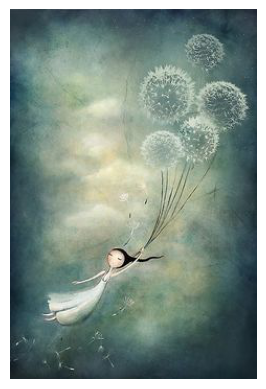

In [2]:
fig = plt.figure()
img = imread(".\cards\card_00001.jpg")
plt.imshow(img);
plt.axis('off');

In [6]:
def show_card(image_path):
    fig = plt.figure()
    img = imread(image_path)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    plt.close(fig)
    return

In [8]:
def plot_random_images(folder = ".\cards", n = 4, seed = None):
 
    '''
    Function that displays n images chosen at random from the specified folder.
    '''

    # Open the folder and handle errors
    try:
        image_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    except FileNotFoundError:
        print(f"[ERROR]: folder '{folder}' not found!")
        return

    if not image_list: # use lists' implicit booleanness
        print(f"[WARNING]: the folder '{folder}' is empty.")
        return
    num_images = min(n, len(image_list))

    if seed:
        random.seed(seed)
    random_images = random.sample(image_list, num_images)

    # Plot
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize = (15, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            img_path = os.path.join(folder, random_images[i])
            img = imread(img_path)
            ax.imshow(img)
            ax.set_title(random_images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    fig.suptitle('Some random cards', fontsize = 20)
    plt.tight_layout()
    plt.show()
    return

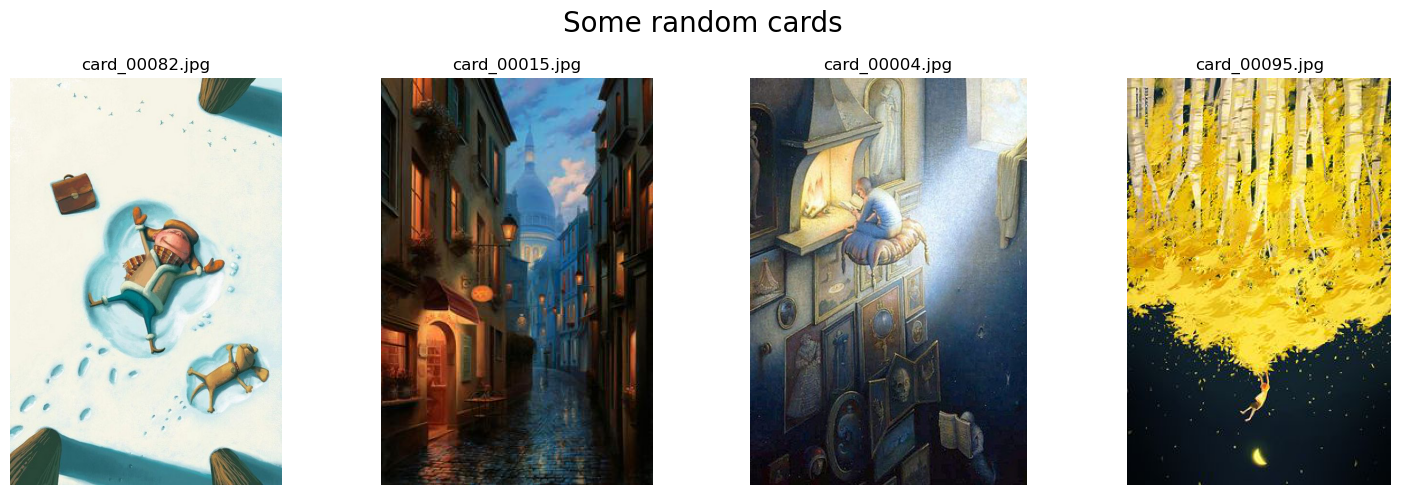

In [9]:
plot_random_images(seed = 42)

#### The CLIP model

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.

<img src = "https://raw.githubusercontent.com/openai/CLIP/refs/heads/main/CLIP.png" width = 1000 />

https://github.com/openai/CLIP

CLIP essentially creates a shared embedding space for images and text, meaning that you could use it to find the most relevant caption (given a selection of captions) for a given image, or vice-versa find the most relevant image for a given text snippet. An important thing to note is that CLIP is not a generative model, i.e. it does not generate the text-snippet or image, you use the embedding space to retrieve a previously embedded item.

https://medium.com/@kerry.halupka/getting-started-with-openais-clip-a3b8f5277867

- Installing CLIP:

In [6]:
# Using Github's implementation

# Installing required dependencies and the CLIP repository
# as a Python package. Use cudatoolkit=11.0 if a CUDA GPU is available, cpuonly otherwise

# ! conda install --yes -c pytorch pytorch=1.7.1 torchvision cpuonly
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed



Examining cpuonly:  83%|████████▎ | 5/6 [00:25<00:03,  3.52s/it]                       
                                                                

Examining conflict for pytorch torchvision:   0%|          | 0/6 [00:00<?, ?it/s]
Examining conflict for pytorch torchvision python:  17%|█▋        | 1/6 [00:02<00:10,  2.02s/it]
Examining conflict for pytorch torchvision python:  33%|███▎      | 2/6 [00:02<00:04,  1.01s/it]
Examining conflict for torchvision cpuonly:  67%|██████▋   | 4/6 [00:06<00:03,  1.78s/it]
                                                                                         

UnsatisfiableError: The following specifications were found to be incompatible with each other:

Output in format: Requested package -> Available versions

Package pytorch-mutex conflicts for:
torchvision -> pytorch-mutex==1.0[build='cpu|cuda']
cpuonly -> pytorch-mutex==1.0=cpu

Package pytorch conflicts for:
pytorch=1.7.1
torchvision -> pytorch[version='1.10.0|1.10.1|1.10.2|1.11.0|1.1

  Cloning https://github.com/openai/CLIP.git to c:\users\cristiana\appdata\local\temp\pip-req-build-4b8em7k_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Cristiana\AppData\Local\Temp\pip-req-build-4b8em7k_'


- Try simple experiments:

In [10]:
import torch
import clip
from PIL import Image

import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [11]:
# List all the CLIP available models
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [12]:
url = "https://raw.githubusercontent.com/openai/CLIP/refs/heads/main/CLIP.png"
response = requests.get(url)

image = preprocess(Image.open(BytesIO(response.content))).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():

    # Encoding image and text with the respective CLIP encoders
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    # Calculation of logit scores (cosine similarity x 100)
    logits_per_image, logits_per_text = model(image, text)
    # - logits_per_image: matrix whose rows contain the logits of an image vs all the text snippets in the batch
    # - logits_per_text: matrix whose rows contain the logits of a text snippet vs all the images in the batch
    
    # Application of softmax function to turn raw logits into probabilities
    probs = logits_per_image.softmax(dim = -1).cpu().numpy()
    # This ensures that:
    # - the probabilities for each row (each image) sum up to 1
    # - higher logit scores correspond to higher matching probabilities

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.99279356 0.00421069 0.00299576]]


In [13]:
def run_clip_demo(image_path, labels):
    '''
    Function used to run some preliminary tests of the CLIP model.
    Task: Image -> Text
    - image is the input image path
    - labels is a list of captions to compare the image with
    '''
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(labels).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print("Label probs:", probs)
    return

Input image:


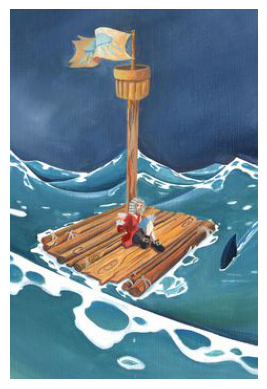

Candidate labels: ['a boat in the middle of the ocean', 'a diagram', 'a dog', 'a cat'] 

Label probs: [[9.9524742e-01 2.0437562e-03 2.0605794e-03 6.4829615e-04]]


In [ ]:
img_path = "./cards/card_00097.jpg"
labels = ["a boat in the middle of the ocean", "a diagram", "a dog", "a cat"]

print("Input image:")
show_card(img_path)

print("Candidate labels:", labels, "\n")

run_clip_demo(img_path, labels)

Input image:


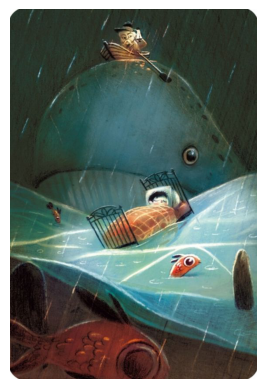

Candidate labels: ['a boat', 'a boy', 'a girl', 'a fish', 'a cat'] 

Label probs: [[0.23969115 0.00499837 0.00100114 0.74920386 0.00510547]]


In [15]:
img_path = "./cards/card_00011.jpg"
labels = ["a boat", "a boy", "a girl", "a fish", "a cat"]

print("Input image:")
show_card(img_path)

print("Candidate labels:", labels, "\n")

run_clip_demo(img_path, labels)

Input image:


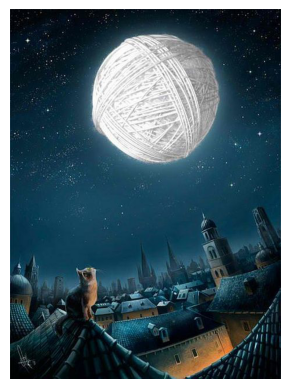

Candidate labels: ['a boat', 'a boy', 'a girl', 'a fish', 'a cat'] 

Label probs: [[0.00961968 0.00320416 0.00204311 0.00812108 0.977012  ]]


In [16]:
img_path = "./cards/card_00023.jpg"

print("Input image:")
show_card(img_path)

print("Candidate labels:", labels, "\n")

run_clip_demo(img_path, labels)

Input image:


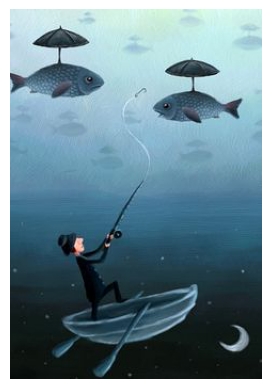

Candidate labels: ['a boat', 'a boy', 'a girl', 'a fish', 'a cat'] 

Label probs: [[0.07673054 0.01196107 0.00424046 0.9056968  0.00137119]]


In [17]:
img_path = "./cards/card_00098.jpg"

print("Input image:")
show_card(img_path)

print("Candidate labels:", labels, "\n")

run_clip_demo(img_path, labels)

Input image:


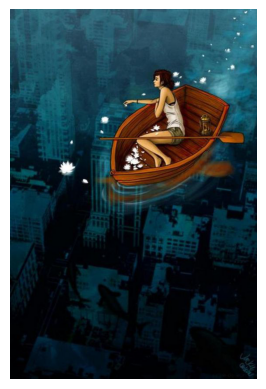

Candidate labels: ['a boat', 'a boy', 'a girl', 'a fish', 'a cat'] 

Label probs: [[0.73048973 0.05991001 0.12167051 0.06783593 0.02009377]]


In [18]:
img_path = "./cards/card_00070.jpg"

print("Input image:")
show_card(img_path)

print("Candidate labels:", labels, "\n")

run_clip_demo(img_path, labels)

From a few simple experiments, we can notice that the model is actually able to associate an image a relevant score for each text snippet that it finds relevant. While this could be an undesirable behaviour for a classification task, because the model seems confused in assigning labels, it's actually good for us as it recognizes multiple elements contained in an image that can be used to describe it. We could use a threshold on the output probabilities to retain all the most relevant objects that the model associates to the image to understand what it contains.

**What kind of scores does CLIP return?**

(Given a batch of images and text tokens, the CLIP model outputs the logit scores for each image and text snippet representing the model's confidence about how well an image matches a text description. These values are cosine similarities between image and text, times 100. Cosine similarity measures the alignment of image and text embeddings and can be used as logit scores at inference to rank image vs text or vice-versa. The Softmax function can then be applied to the logit scores to quantify as a probability the model's confidence in matching image-text pairs and can be further used in tasks like retrieval and classification.)

### Zero-Shot Prediction with CIFAR-100 labels

The CIFAR-100 dataset contains 100 classes grouped into 20 superclasses (aquatic mammals, fish, flowers, food containers, fruit and vegetables, household electrical devices, household furniture, insects, large carnivores, large man-made outdoor things, large natural outdoor scenes, large omnivores and herbivores, medium-sized mammals, non-insect invertebrates, people, reptiles, small mammals, trees, vehicles 1, vehicles 2).

In [19]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

- OpenAI CLIP example:

Files already downloaded and verified


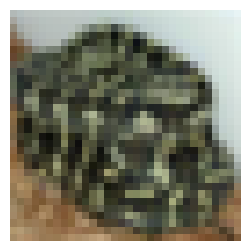

Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


In [32]:
# Load the model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]

plt.figure(figsize = (3, 3))  
plt.imshow(image)
plt.axis('off')
plt.show()

image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("Top predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

- Let's try and see what are the top 5 classes retrieved for the 98th image:

Input image:


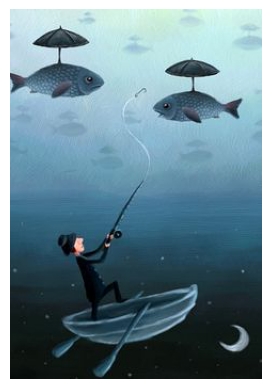

Top predictions:

   aquarium_fish: 50.17%
           trout: 17.90%
             ray: 9.80%
        flatfish: 7.12%
             sea: 5.92%
             man: 0.96%
           whale: 0.83%
           shark: 0.76%
             boy: 0.74%
           plate: 0.53%


In [37]:
# Prepare input image
img_path = "./cards/card_00098.jpg"
print("Input image:")
show_card(img_path)

image_input = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

# Print the result
print("Top predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

Okay, so the model outputs an interesting ranking of labels: the first four all identify various types of fish, which are accurate as there are many fish in the image but redundant. For a conceptual description, we don't really care about the fish species. Also "sea" and "man" are retrieved, however with lower probabilities indicating lower matching. Although, this would probably change if we removed all the fish synonyms that preceed them in the ranking. Also, I inspected the whole list of classes with their probability to see if the boat and the moon have been spotted by the model or not, but as a matter of fact those words are not included in the CIFAR-100 set of labels at all. <br>
In conclusion, we can say that CLIP returns promising results that may be refined with a vocabulary of labels built ad-hoc. <br>


In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")            # CLIP model 
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")    # CLIP processor

In [2]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [3]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, sp

- Model: it probably comes as no surprise that this is the CLIP model. What might interest you more though is that under the hood it’s actually two models! This is because CLIP uses a ViT-like transformer to get visual features and a causal language model to get the text features, this class wraps up both of these pieces.
- Processor: The CLIPProcessor also wraps up two pieces: the CLIPFeatureExtractor to prepare the images for the image network, and the CLIPTokenizer, which encodes text ready for the language model.
- Both Model and Processor require a config to be specified (I’ve specified openai/clip-vit-base-patch32 , which uses a ViT-B/32 Transformer architecture as an image encoder and, a masked self-attention Transformer as a text encoder). You need to use the same config string for both, otherwise you won’t have a good time.

- It's easy to test out other model configs, just search on HuggingFace

In [5]:
import torch
print(torch.__version__)

1.13.1+cpu


In [1]:
# Using directly Github's implemenatation
#! pip install torchvision
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

# Using Huggingface's transformers
#! pip install torch==2.2
#! python -m venv .env
#! .env/Scripts/activate
#! pip install transformers

### References

A list of the main literary references used in this project is reported below:

- Kunda, M., & Rabkina, I. (2020). Creative Captioning: An AI Grand Challenge Based on the Dixit Board Game. arXiv preprint arXiv:2010.00048.
[Link](https://arxiv.org/abs/2010.00048)
- Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021, July). Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748-8763). PMLR.
[Link](https://arxiv.org/abs/2103.00020)